# DQN 기초: CartPole-v1 🎯

> **학습 목표:** DQN의 핵심 개념을 CartPole 환경에서 처음부터 구현하며 학습하기

---

## 📋 CartPole 환경 소개

```
목표: 카트 위의 막대를 쓰러뜨리지 않고 균형 유지

┌─────────────────────┐
│      │               │  막대가 쓰러지지 않게!
│      │               │
│    [====]            │  카트를 좌우로 움직임
└─────────────────────┘
```

### 환경 정보
- **상태 (State):** 4차원 벡터
  - `[0]` 카트 위치 (Cart Position): -4.8 ~ 4.8
  - `[1]` 카트 속도 (Cart Velocity): -∞ ~ ∞
  - `[2]` 막대 각도 (Pole Angle): -0.418 rad ~ 0.418 rad
  - `[3]` 막대 각속도 (Pole Angular Velocity): -∞ ~ ∞

- **행동 (Action):** 2개
  - `0`: 왼쪽으로 밀기
  - `1`: 오른쪽으로 밀기

- **보상 (Reward):** 매 스텝마다 +1
  - 막대가 서 있으면 보상

- **종료 조건:**
  - 막대 각도가 ±12도 이상
  - 카트 위치가 ±2.4 이상
  - 200 스텝 달성 (성공!)

- **목표:** 100 에피소드 평균 195점 이상

---

## 🎓 이 노트북에서 배울 내용

1. ✅ **Replay Buffer** 구현
2. ✅ **Q-Network** (Neural Network) 구현
3. ✅ **Target Network** 사용법
4. ✅ **ε-greedy** 탐색 전략
5. ✅ **DQN 학습 루프** 구현
6. ✅ **학습 결과 분석 및 시각화**


## 1. 라이브러리 임포트 📚


In [2]:
# ========================================
# 필수 라이브러리 임포트
# ========================================

# Gym: OpenAI의 강화학습 환경 라이브러리
import gymnasium as gym

# 수치 계산
import numpy as np

# PyTorch: 딥러닝 프레임워크
import torch
import torch.nn as nn           # Neural Network 모듈
import torch.optim as optim     # 최적화 알고리즘 (Adam, SGD 등)
import torch.nn.functional as F # 활성화 함수 등

# 데이터 구조
from collections import deque   # Replay Buffer용 (FIFO 큐)
import random                   # 랜덤 샘플링

# 시각화
import matplotlib.pyplot as plt
from IPython.display import clear_output  # 실시간 플롯 업데이트용

# ========================================
# GPU 설정
# ========================================
# CUDA(GPU) 사용 가능하면 GPU, 아니면 CPU 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Using device: {device}")

# GPU 정보 출력 (사용 가능한 경우)
if torch.cuda.is_available():
    print(f"   GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


🖥️  Using device: cpu


## 2. Replay Buffer 구현 🗄️

**Experience Replay란?**
- DQN의 핵심 기법 중 하나
- 과거 경험 `(s, a, r, s', done)`을 메모리에 저장
- 학습 시 **랜덤하게 샘플링**하여 사용

**왜 필요한가?**
1. **시간적 상관성 제거**: 연속된 경험은 비슷함 → 랜덤 샘플링으로 해결
2. **샘플 효율성 향상**: 한 번의 경험을 여러 번 재사용
3. **학습 안정화**: i.i.d(독립 동일 분포) 가정에 가까워짐

**구조:**
```python
deque(maxlen=capacity)  # FIFO 큐 (오래된 것 자동 삭제)
```


In [ ]:
class ReplayBuffer:
    """
    Experience Replay Buffer
    
    과거 경험(transition)을 저장하고, 학습 시 랜덤하게 샘플링하는 버퍼
    """
    
    def __init__(self, capacity=10000):
        """
        Args:
            capacity (int): 버퍼의 최대 크기
                - 가득 차면 가장 오래된 경험이 자동으로 삭제됨 (FIFO)
        """
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        """
        하나의 transition을 버퍼에 추가
        
        Args:
            state: 현재 상태 (numpy array)
            action: 선택한 행동 (int)
            reward: 받은 보상 (float)
            next_state: 다음 상태 (numpy array)
            done: 에피소드 종료 여부 (bool)
        """
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        """
        버퍼에서 랜덤하게 batch_size만큼 샘플링
        
        Args:
            batch_size (int): 샘플링할 개수
            
        Returns:
            tuple: (states, actions, rewards, next_states, dones)
                - 각각 numpy array로 반환
        """
        # 랜덤하게 batch_size개 선택
        batch = random.sample(self.buffer, batch_size)
        
        # [(s,a,r,s',d), ...] → ([s,...], [a,...], [r,...], [s',...], [d,...])
        states, actions, rewards, next_states, dones = zip(*batch)
        
        return (
            np.array(states),                        # (batch_size, state_dim)
            np.array(actions),                       # (batch_size,)
            np.array(rewards, dtype=np.float32),     # (batch_size,)
            np.array(next_states),                   # (batch_size, state_dim)
            np.array(dones, dtype=np.float32)        # (batch_size,)
        )
    
    def __len__(self):
        """버퍼에 저장된 경험의 개수"""
        return len(self.buffer)


# ========================================
# 테스트: Replay Buffer가 잘 작동하는지 확인
# ========================================
print("📦 Replay Buffer 테스트\\n" + "="*50)

# 버퍼 생성 (최대 5개 저장)
test_buffer = ReplayBuffer(capacity=5)

# 샘플 데이터 추가
test_buffer.push([1,2,3,4], 0, 1.0, [2,3,4,5], False)
test_buffer.push([2,3,4,5], 1, 1.0, [3,4,5,6], False)
test_buffer.push([3,4,5,6], 0, -1.0, [4,5,6,7], True)

print(f"✅ Buffer size: {len(test_buffer)}")
print(f"✅ Buffer capacity: 5")
print(f"\\n📝 샘플 데이터 저장 완료!")
print("="*50)


📦 Replay Buffer 테스트\n==================================================
✅ Buffer size: 3
✅ Buffer capacity: 5
\n📝 샘플 데이터 저장 완료!


## 3. Q-Network 구현 🧠

**Q-Network란?**
- Q-Table을 **Neural Network**로 대체
- 입력: 상태 `s` (4차원 벡터)
- 출력: 각 행동의 Q값 `[Q(s,a₀), Q(s,a₁)]` (2개)

**구조:**
```
Input (4) → FC(128) → ReLU → FC(128) → ReLU → FC(2) → Output
```

**왜 Neural Network를 사용하는가?**
- ✅ 연속 상태 공간 처리 가능
- ✅ 일반화 능력 (비슷한 상태 → 비슷한 Q값)
- ✅ 고차원 입력 처리 가능 (이미지 등)


In [4]:
class DQN(nn.Module):
    """
    Deep Q-Network
    
    Neural Network로 Q-Function을 근사하는 모델
    """
    
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        """
        Args:
            state_dim (int): 상태 공간의 차원 (CartPole: 4)
            action_dim (int): 행동 공간의 크기 (CartPole: 2)
            hidden_dim (int): 은닉층의 뉴런 개수
        """
        super(DQN, self).__init__()
        
        # 레이어 정의
        self.fc1 = nn.Linear(state_dim, hidden_dim)    # 입력층 → 은닉층1
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)   # 은닉층1 → 은닉층2
        self.fc3 = nn.Linear(hidden_dim, action_dim)   # 은닉층2 → 출력층
    
    def forward(self, x):
        """
        순전파 (Forward Pass)
        
        Args:
            x (torch.Tensor): 상태 벡터 (batch_size, state_dim)
            
        Returns:
            torch.Tensor: Q-values for each action (batch_size, action_dim)
        """
        x = F.relu(self.fc1(x))  # 첫 번째 은닉층 + ReLU 활성화
        x = F.relu(self.fc2(x))  # 두 번째 은닉층 + ReLU 활성화
        return self.fc3(x)        # 출력층 (활성화 함수 없음)


# ========================================
# 테스트: Q-Network가 잘 작동하는지 확인
# ========================================
print("🧠 Q-Network 테스트\\n" + "="*50)

# CartPole 환경의 차원
state_dim = 4   # [카트 위치, 카트 속도, 막대 각도, 막대 각속도]
action_dim = 2  # [왼쪽, 오른쪽]

# Q-Network 생성
q_net = DQN(state_dim, action_dim, hidden_dim=128).to(device)

# 네트워크 구조 출력
print("Network Architecture:")
print(q_net)
print("="*50)

# 샘플 입력으로 테스트
sample_state = torch.FloatTensor([[1.0, 0.5, 0.1, -0.2]]).to(device)
print(f"\\n📥 Input (state): {sample_state.cpu().numpy()}")

# 순전파
q_values = q_net(sample_state)
print(f"📤 Output (Q-values): {q_values.detach().cpu().numpy()}")
print(f"\\n🎯 Best action: {torch.argmax(q_values).item()} (0=왼쪽, 1=오른쪽)")
print(f"   Q(s, left)  = {q_values[0, 0].item():.4f}")
print(f"   Q(s, right) = {q_values[0, 1].item():.4f}")

# 파라미터 개수 계산
total_params = sum(p.numel() for p in q_net.parameters())
print(f"\\n📊 Total Parameters: {total_params:,}")
print("="*50)


🧠 Q-Network 테스트\n==================================================
Network Architecture:
DQN(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)
\n📥 Input (state): [[ 1.   0.5  0.1 -0.2]]
📤 Output (Q-values): [[-0.19981402  0.01220229]]
\n🎯 Best action: 1 (0=왼쪽, 1=오른쪽)
   Q(s, left)  = -0.1998
   Q(s, right) = 0.0122
\n📊 Total Parameters: 17,410


## 4. DQN Agent 구현 🤖

**DQN Agent의 핵심 구성 요소:**
1. **Q-Network**: 학습할 네트워크
2. **Target Network**: 학습 안정화용 네트워크 (가중치 고정)
3. **Replay Buffer**: 경험 저장소
4. **ε-greedy**: 탐색(Exploration) vs 활용(Exploitation) 균형

**Target Network의 역할:**
- TD Target 계산 시 사용
- 일정 주기마다만 Q-Network의 가중치를 복사
- "Moving Target Problem" 해결 → 학습 안정화


In [5]:
class DQNAgent:
    """
    DQN 에이전트
    
    Q-Learning을 Deep Neural Network로 구현한 에이전트
    """
    
    def __init__(
        self,
        state_dim,
        action_dim,
        lr=1e-3,           # Learning Rate (학습률)
        gamma=0.99,        # Discount Factor (할인율)
        epsilon_start=1.0, # 초기 탐험 확률
        epsilon_end=0.01,  # 최소 탐험 확률
        epsilon_decay=0.995 # 탐험 확률 감소율
    ):
        """
        Args:
            state_dim (int): 상태 공간 차원
            action_dim (int): 행동 공간 크기
            lr (float): 학습률
            gamma (float): 할인율 (0 ≤ γ < 1)
            epsilon_start (float): 초기 ε값
            epsilon_end (float): 최소 ε값
            epsilon_decay (float): ε 감소율
        """
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        
        # ========================================
        # Q-Network와 Target Network 생성
        # ========================================
        # Q-Network: 학습할 네트워크
        self.q_net = DQN(state_dim, action_dim).to(device)
        
        # Target Network: 학습 안정화용 (가중치 고정)
        self.target_net = DQN(state_dim, action_dim).to(device)
        self.target_net.load_state_dict(self.q_net.state_dict())  # 가중치 복사
        self.target_net.eval()  # 평가 모드 (학습 안 함)
        
        # ========================================
        # 최적화 알고리즘
        # ========================================
        # Adam: 학습률을 자동으로 조정하는 최적화 알고리즘
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        
        # ========================================
        # Replay Buffer
        # ========================================
        self.replay_buffer = ReplayBuffer(capacity=10000)
        
        # ========================================
        # ε-greedy 파라미터
        # ========================================
        self.epsilon = epsilon_start      # 현재 ε값
        self.epsilon_end = epsilon_end    # 최소값
        self.epsilon_decay = epsilon_decay  # 감소율
    
    def select_action(self, state):
        """
        ε-greedy 정책으로 행동 선택
        
        - ε 확률로 랜덤 행동 (탐험, Exploration)
        - (1-ε) 확률로 최선의 행동 (활용, Exploitation)
        
        Args:
            state (numpy.array): 현재 상태
            
        Returns:
            int: 선택한 행동
        """
        if random.random() < self.epsilon:
            # 탐험: 랜덤 행동 선택
            return random.randrange(self.action_dim)
        else:
            # 활용: Q값이 최대인 행동 선택
            state = torch.FloatTensor(state).unsqueeze(0).to(device)  # (1, state_dim)
            
            with torch.no_grad():  # 그래디언트 계산 X (추론만)
                q_values = self.q_net(state)  # (1, action_dim)
            
            return torch.argmax(q_values).item()  # argmax → 스칼라 값
    
    def train(self, batch_size=64):
        """
        배치 학습
        
        1. Replay Buffer에서 랜덤 샘플링
        2. TD Target 계산 (Target Network 사용)
        3. Loss 계산 및 역전파
        
        Args:
            batch_size (int): 배치 크기
            
        Returns:
            float: Loss 값 (None if buffer size < batch_size)
        """
        # 버퍼에 데이터가 충분하지 않으면 학습 스킵
        if len(self.replay_buffer) < batch_size:
            return None
        
        # ========================================
        # 1. 배치 샘플링
        # ========================================
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)
        
        # Numpy → PyTorch Tensor로 변환
        states = torch.FloatTensor(states).to(device)       # (batch_size, state_dim)
        actions = torch.LongTensor(actions).to(device)      # (batch_size,)
        rewards = torch.FloatTensor(rewards).to(device)     # (batch_size,)
        next_states = torch.FloatTensor(next_states).to(device)  # (batch_size, state_dim)
        dones = torch.FloatTensor(dones).to(device)         # (batch_size,)
        
        # ========================================
        # 2. Current Q-values 계산
        # ========================================
        # Q-Network로 현재 상태의 Q값 계산
        current_q_values = self.q_net(states)  # (batch_size, action_dim)
        
        # 실제로 선택한 행동의 Q값만 추출
        current_q_values = current_q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
        # gather: actions에 해당하는 인덱스의 값만 선택
        # (batch_size, action_dim) → (batch_size,)
        
        # ========================================
        # 3. Target Q-values 계산 (Target Network 사용)
        # ========================================
        with torch.no_grad():  # 그래디언트 계산 X (Target Network는 학습 안 함)
            # 다음 상태의 최대 Q값 계산
            next_q_values = self.target_net(next_states)  # (batch_size, action_dim)
            next_q_values = next_q_values.max(1)[0]  # max → (values, indices)
            # (batch_size, action_dim) → (batch_size,)
            
            # TD Target = r + γ * max Q(s', a') * (1 - done)
            # done=True이면 미래 보상 없음 (에피소드 종료)
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values
        
        # ========================================
        # 4. Loss 계산 (MSE Loss)
        # ========================================
        # Loss = (TD Target - Current Q)^2
        loss = F.mse_loss(current_q_values, target_q_values)
        
        # ========================================
        # 5. 역전파 및 가중치 업데이트
        # ========================================
        self.optimizer.zero_grad()  # 그래디언트 초기화
        loss.backward()              # 역전파 (그래디언트 계산)
        self.optimizer.step()        # 가중치 업데이트
        
        return loss.item()  # Loss 값 반환 (로깅용)
    
    def update_target_network(self):
        """
        Target Network 업데이트
        
        Q-Network의 가중치를 Target Network에 복사
        일정 주기마다 호출됨 (예: 10 에피소드마다)
        """
        self.target_net.load_state_dict(self.q_net.state_dict())
    
    def decay_epsilon(self):
        """
        ε 감소
        
        학습이 진행될수록 탐험을 줄이고 활용을 늘림
        ε = ε * decay_rate (단, ε ≥ ε_min)
        """
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)


# ========================================
# 테스트: DQN Agent 생성
# ========================================
print("🤖 DQN Agent 테스트\\n" + "="*50)

# Agent 생성
test_agent = DQNAgent(
    state_dim=4,
    action_dim=2,
    lr=1e-3,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.01,
    epsilon_decay=0.995
)

print("✅ DQN Agent 생성 완료!")
print(f"   - State dimension: {test_agent.state_dim}")
print(f"   - Action dimension: {test_agent.action_dim}")
print(f"   - Epsilon: {test_agent.epsilon}")
print(f"   - Gamma: {test_agent.gamma}")
print(f"   - Buffer capacity: {test_agent.replay_buffer.buffer.maxlen}")
print("="*50)


🤖 DQN Agent 테스트\n==================================================
✅ DQN Agent 생성 완료!
   - State dimension: 4
   - Action dimension: 2
   - Epsilon: 1.0
   - Gamma: 0.99
   - Buffer capacity: 10000


## 5. 학습 함수 및 실행 🚀


In [6]:
# ========================================
# 환경 생성
# ========================================
env = gym.make('CartPole-v1')

# 환경 정보 출력
print("🎮 CartPole-v1 Environment")
print("="*50)
print(f"상태 공간: {env.observation_space}")
print(f"  - Shape: {env.observation_space.shape}")
print(f"행동 공간: {env.action_space}")
print(f"  - 행동 개수: {env.action_space.n}")
print("="*50)

# ========================================
# Agent 생성
# ========================================
state_dim = env.observation_space.shape[0]  # 4
action_dim = env.action_space.n  # 2

agent = DQNAgent(
    state_dim=state_dim,
    action_dim=action_dim,
    lr=1e-3,            # 학습률
    gamma=0.99,         # 할인율
    epsilon_start=1.0,  # 초기 ε (100% 탐험)
    epsilon_end=0.01,   # 최소 ε (1% 탐험)
    epsilon_decay=0.995 # ε 감소율
)

print("\\n🤖 Agent 생성 완료!")
print("="*50)

# ========================================
# 학습 하이퍼파라미터
# ========================================
num_episodes = 500          # 총 에피소드 수
target_update_freq = 10     # Target Network 업데이트 주기
batch_size = 64             # 배치 크기
print_freq = 10             # 출력 주기

print(f"\\n⚙️  학습 설정")
print("="*50)
print(f"총 에피소드: {num_episodes}")
print(f"배치 크기: {batch_size}")
print(f"Target 업데이트 주기: {target_update_freq} episodes")
print("="*50)

# ========================================
# 학습 기록용 리스트
# ========================================
scores = []      # 에피소드별 점수
losses = []      # 에피소드별 평균 loss
epsilons = []    # 에피소드별 epsilon 값

print("\\n🎓 학습 시작!\\n")

# ========================================
# 학습 루프
# ========================================
for episode in range(num_episodes):
    # 환경 리셋
    state, _ = env.reset()
    total_reward = 0
    episode_losses = []
    done = False
    
    # 에피소드 진행
    while not done:
        # ========================================
        # 1. 행동 선택 (ε-greedy)
        # ========================================
        action = agent.select_action(state)
        
        # ========================================
        # 2. 환경에서 한 스텝 실행
        # ========================================
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        # ========================================
        # 3. Replay Buffer에 경험 저장
        # ========================================
        agent.replay_buffer.push(state, action, reward, next_state, done)
        
        # ========================================
        # 4. 배치 학습
        # ========================================
        loss = agent.train(batch_size=batch_size)
        if loss is not None:
            episode_losses.append(loss)
        
        # 상태 업데이트
        state = next_state
        total_reward += reward
    
    # ========================================
    # 에피소드 종료 후 처리
    # ========================================
    
    # Epsilon 감소
    agent.decay_epsilon()
    
    # Target Network 업데이트 (주기적으로)
    if episode % target_update_freq == 0:
        agent.update_target_network()
    
    # 기록
    scores.append(total_reward)
    avg_loss = np.mean(episode_losses) if episode_losses else 0
    losses.append(avg_loss)
    epsilons.append(agent.epsilon)
    
    # ========================================
    # 진행 상황 출력
    # ========================================
    if episode % print_freq == 0:
        avg_score = np.mean(scores[-10:])  # 최근 10개 평균
        print(f"Episode {episode:4d} | "
              f"Score: {total_reward:6.2f} | "
              f"Avg(10): {avg_score:6.2f} | "
              f"Loss: {avg_loss:6.4f} | "
              f"ε: {agent.epsilon:.3f} | "
              f"Buffer: {len(agent.replay_buffer)}")
    
    # ========================================
    # 성공 조건 체크 (CartPole: 평균 195점 이상)
    # ========================================
    if len(scores) >= 100 and np.mean(scores[-100:]) >= 195:
        print(f"\\n🎉 환경 해결! (Episode {episode})")
        print(f"   최근 100 에피소드 평균: {np.mean(scores[-100:]):.2f}")
        break

print("\\n✅ 학습 완료!")
print("="*50)


🎮 CartPole-v1 Environment
상태 공간: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
  - Shape: (4,)
행동 공간: Discrete(2)
  - 행동 개수: 2
\n🤖 Agent 생성 완료!
\n⚙️  학습 설정
총 에피소드: 500
배치 크기: 64
Target 업데이트 주기: 10 episodes
\n🎓 학습 시작!\n
Episode    0 | Score:  26.00 | Avg(10):  26.00 | Loss: 0.0000 | ε: 0.995 | Buffer: 26
Episode   10 | Score:  26.00 | Avg(10):  20.10 | Loss: 0.0003 | ε: 0.946 | Buffer: 227
Episode   20 | Score:  31.00 | Avg(10):  20.10 | Loss: 0.0391 | ε: 0.900 | Buffer: 428
Episode   30 | Score:  16.00 | Avg(10):  24.80 | Loss: 0.0666 | ε: 0.856 | Buffer: 676
Episode   40 | Score:  26.00 | Avg(10):  24.80 | Loss: 0.1153 | ε: 0.814 | Buffer: 924
Episode   50 | Score:  24.00 | Avg(10):  35.70 | Loss: 0.1462 | ε: 0.774 | Buffer: 1281
Episode   60 | Score:  48.00 | Avg(10):  20.60 | Loss: 0.1723 | ε: 0.737 | Buffer: 1487
Episode   70 | Score:  32.00 | Avg(10):  34.00 | Loss: 0.1542 | ε: 0.701 | Buffer: 1827
Episode   80

## 6. 학습 결과 시각화 📊


/var/folders/s9/hs4fj__n5lx5m_tgwjn9c10m0000gn/T/ipykernel_67314/3335227392.py:47: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/var/folders/s9/hs4fj__n5lx5m_tgwjn9c10m0000gn/T/ipykernel_67314/3335227392.py:47: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
/var/folders/s9/hs4fj__n5lx5m_tgwjn9c10m0000gn/T/ipykernel_67314/3335227392.py:47: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
/Users/taeinyong/opt/anaconda3/envs/battery/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/taeinyong/opt/anaconda3/envs/battery/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.

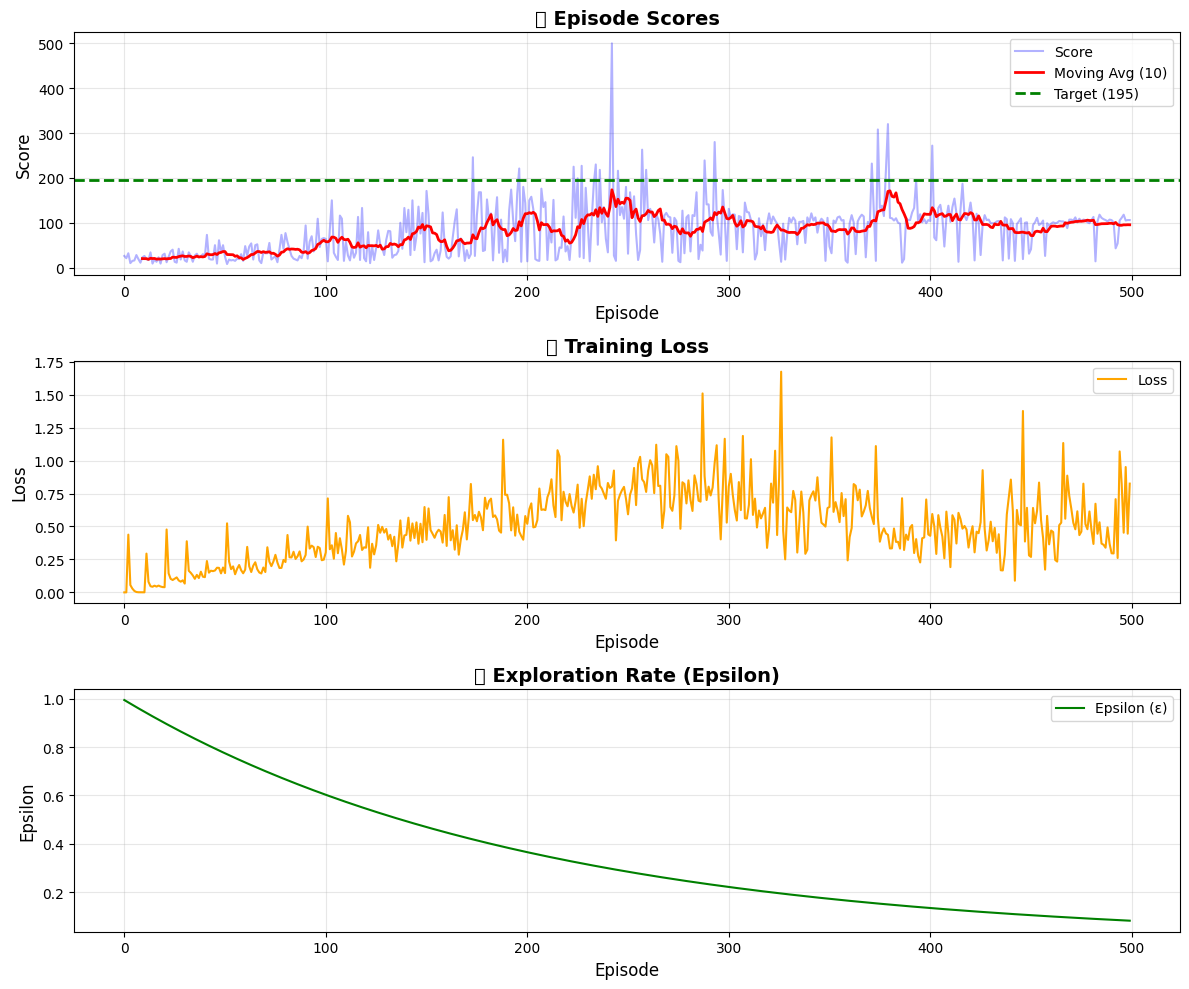

\n📊 학습 통계
총 에피소드: 500
최고 점수: 500.00
최저 점수: 8.00
평균 점수: 80.96
마지막 100 에피소드 평균: 98.21
최종 Epsilon: 0.0816


In [7]:
# ========================================
# 학습 결과 시각화
# ========================================

fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# ========================================
# 1. 점수 그래프
# ========================================
axes[0].plot(scores, alpha=0.3, label='Score', color='blue')

# 이동 평균 계산
window = 10
moving_avg = np.convolve(scores, np.ones(window)/window, mode='valid')
axes[0].plot(range(window-1, len(scores)), moving_avg, 
             label=f'Moving Avg ({window})', linewidth=2, color='red')

# 목표선 표시 (CartPole 해결 조건: 195점)
axes[0].axhline(y=195, color='green', linestyle='--', label='Target (195)', linewidth=2)

axes[0].set_xlabel('Episode', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('📈 Episode Scores', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# ========================================
# 2. Loss 그래프
# ========================================
axes[1].plot(losses, label='Loss', color='orange', linewidth=1.5)
axes[1].set_xlabel('Episode', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('📉 Training Loss', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# ========================================
# 3. Epsilon 그래프
# ========================================
axes[2].plot(epsilons, label='Epsilon (ε)', color='green', linewidth=1.5)
axes[2].set_xlabel('Episode', fontsize=12)
axes[2].set_ylabel('Epsilon', fontsize=12)
axes[2].set_title('🔍 Exploration Rate (Epsilon)', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========================================
# 통계 출력
# ========================================
print("\\n📊 학습 통계")
print("="*50)
print(f"총 에피소드: {len(scores)}")
print(f"최고 점수: {max(scores):.2f}")
print(f"최저 점수: {min(scores):.2f}")
print(f"평균 점수: {np.mean(scores):.2f}")
print(f"마지막 100 에피소드 평균: {np.mean(scores[-100:]):.2f}")
print(f"최종 Epsilon: {epsilons[-1]:.4f}")
print("="*50)


## 7. 학습된 에이전트 테스트 🧪


🧪 학습된 에이전트 테스트 중...\n
Test Episode  1 | Score: 109.00 | Steps: 109
Test Episode  2 | Score: 104.00 | Steps: 104
Test Episode  3 | Score: 103.00 | Steps: 103
Test Episode  4 | Score: 109.00 | Steps: 109
Test Episode  5 | Score: 105.00 | Steps: 105
Test Episode  6 | Score: 105.00 | Steps: 105
Test Episode  7 | Score: 104.00 | Steps: 104
Test Episode  8 | Score: 103.00 | Steps: 103
Test Episode  9 | Score: 104.00 | Steps: 104
Test Episode 10 | Score: 106.00 | Steps: 106
\n==================================================
평균 점수: 105.20 ± 2.09
최고 점수: 109.00
최저 점수: 103.00


/var/folders/s9/hs4fj__n5lx5m_tgwjn9c10m0000gn/T/ipykernel_67314/3672708610.py:80: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  plt.tight_layout()
/Users/taeinyong/opt/anaconda3/envs/battery/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


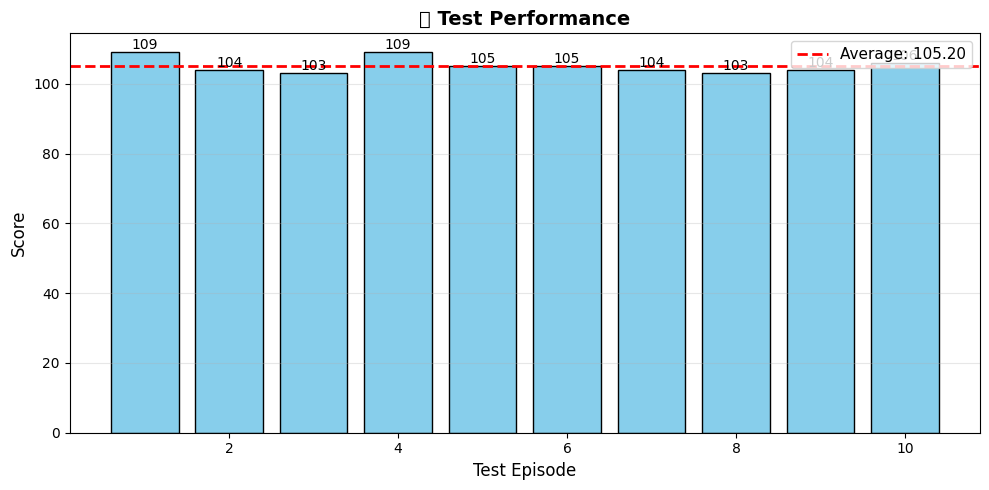